In [1]:
# Wind Capacity Prediction

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from enum import Enum
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn import svm

paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv",
         "era5_regions": "resources/europe-2013-era5-regions.nc"}

In [3]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:           (region: 65, time: 8760)
Coordinates:
  * region            (region) object 'AL0 0 on' 'AT0 0 on' ... 'SI0 0 off'
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    height            (region, time) float64 ...
    wnd100m           (region, time) float64 ...
    roughness         (region, time) float64 ...
    influx_toa        (region, time) float64 ...
    influx_direct     (region, time) float64 ...
    influx_diffuse    (region, time) float64 ...
    albedo            (region, time) float64 ...
    temperature       (region, time) float64 ...
    soil_temperature  (region, time) float64 ...
    runoff            (region, time) float64 ...
Attributes:
    description:  Era5 data with mean value of the coordinates within a region

In [4]:
capfacts = pd.read_csv(paths["capfacs"])
capfacts

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


In [5]:
capfacts_dk = capfacts.filter(regex="DK.*")

## Countries for optimizing hyperparameters

Countries with the highest [installed wind power capacity](https://en.wikipedia.org/wiki/Wind_power_in_the_European_Union) in 2021:
1. Germany
2. Spain
3. UK
4. France
5. Sweden

Countries where wind covers the highest [percentage of the electricity demand](https://windeurope.org/wp-content/uploads/files/about-wind/statistics/WindEurope-Annual-Statistics-2019.pdf) in 2019:
1. Denmark
2. Ireland
3. Portugal
4. Germany
5. UK
6. Spain

In [6]:
# ds["region"].values


### Denmark (DK)

- 08 DK0 0 on: 48 points
- 09 DK4 0 on: 10 points
- 41 DK0 0 off: 135 points
- 42 DK4 0 off: 38 points

In [7]:
ds.sel(region="DK0 0 on")

<xarray.Dataset>
Dimensions:           (time: 8760)
Coordinates:
    region            <U8 'DK0 0 on'
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    height            (time) float64 ...
    wnd100m           (time) float64 ...
    roughness         (time) float64 ...
    influx_toa        (time) float64 ...
    influx_direct     (time) float64 ...
    influx_diffuse    (time) float64 ...
    albedo            (time) float64 ...
    temperature       (time) float64 ...
    soil_temperature  (time) float64 ...
    runoff            (time) float64 ...
Attributes:
    description:  Era5 data with mean value of the coordinates within a region

In [8]:
class EnergyType(Enum):
    OFFWIND_AC = "offwind-ac"
    OFFWIND_DC = "offwind-dc"
    ONWIND = "onwind-dc"
    SOLAR = "solar"
    ROR = "ror"
    NOT_DEFINED = "not_defined"

class Feature(Enum):
    HEIGHT = "height"
    WND100M = "wnd100m"
    ROUGHNESS = "roughness"
    INFLUX_TOA = "influx_toa"
    INFLUX_DIRECT = "influx_direct"
    INFLUX_DIFFUSE = "influx_diffuse"
    ALBEDO = "albedo"
    TEMPERATURE = "temperature"
    SOIL_TEMPERATURE = "soil_temperature"
    RUNOFF = "runoff"

feature_set = {
    EnergyType.OFFWIND_AC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.OFFWIND_DC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.ONWIND: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.SOLAR: [Feature.INFLUX_TOA, Feature.INFLUX_DIRECT, Feature.INFLUX_DIFFUSE, Feature.TEMPERATURE],
    EnergyType.ROR: []
}


def get_energy_type(name: str) -> EnergyType:
    match name:
        case "offwind-ac":
            return EnergyType.OFFWIND_AC
        case "offwind-dc":
            return EnergyType.OFFWIND_DC
        case "onwind":
            return EnergyType.ONWIND
        case "solar":
            return EnergyType.SOLAR
        case "ror":
            return EnergyType.ROR
        case _:
            return EnergyType.NOT_DEFINED

def get_ds_region_name(region_name: str, energy_type: EnergyType) -> str:
    ds_region_name = region_name + " 0"
    if energy_type == EnergyType.ONWIND or energy_type == EnergyType.SOLAR or energy_type == EnergyType.ROR:
        ds_region_name += " on"
    elif energy_type == EnergyType.OFFWIND_AC or energy_type == EnergyType.OFFWIND_DC:
        ds_region_name += " off"
    else:
        ds_region_name += ""
    return ds_region_name

def parse_capfac_col(column_name: str) -> (str, EnergyType):
    col_args = column_name.split(" ")
    if len(col_args) == 3:
        region_name = col_args[0]
        energy_type = get_energy_type(col_args[2])
        return region_name, energy_type
    return None, None

def create_training_data_for_col(column_name: str) -> (np.ndarray, dict):
    region_name, energy_type = parse_capfac_col(column_name)
    ds_region_name = get_ds_region_name(region_name, energy_type)
    features = feature_set.get(energy_type)

    Y_capfac = capfacts[column_name].values
    X = {}
    for feature in features:
        X[feature] = ds.sel(region=ds_region_name)[feature.value].values

    return Y_capfac, X


def shape_multi_feature_data(training_data: dict):
    """
    Reshapes the trainingsdata in an array of shape (n_samples, n_features)
    (8760, 2) ---> [[x_f1_1, x_f2_1], [x_f1_2, x_f2_2], ... , [x_f1_8760, x_f2_8760]]
    :param training_data as a dictinary of multiple 1-d arrays:
    :return: trainingsdata in array of shape (n_samples, n_features)
    """
    # tup = tuple(list(training_data.values()))
    # multi_feature_train_data = np.column_stack(tup)
    arrays = list(training_data.values())
    return np.stack(arrays, axis=-1)



In [9]:
# region_name = "DK0 0 on"
#
# X_height = ds.sel(region=region_name)["height"].values
# X_wnd100m = ds.sel(region=region_name)["wnd100m"].values
# X_roughness = ds.sel(region=region_name)["roughness"].values
# X_influx_toa = ds.sel(region=region_name)["influx_toa"].values
# X_influx_direct = ds.sel(region=region_name)["influx_direct"].values
# X_influx_diffuse = ds.sel(region=region_name)["influx_diffuse"].values
# X_albedo = ds.sel(region=region_name)["albedo"].values
# X_temperature = ds.sel(region=region_name)["temperature"].values
# X_soil_temperature = ds.sel(region=region_name)["soil_temperature"].values
# X_runoff = ds.sel(region=region_name)["runoff"].values

In [10]:
for column in capfacts:
    print(column)
    # print(parse_capfac_col(column))

snapshot
AL0 0 offwind-ac
AL0 0 onwind
AL0 0 solar
AT0 0 onwind
AT0 0 ror
AT0 0 solar
BA0 0 onwind
BA0 0 solar
BE0 0 offwind-ac
BE0 0 offwind-dc
BE0 0 onwind
BE0 0 ror
BE0 0 solar
BG0 0 offwind-ac
BG0 0 offwind-dc
BG0 0 onwind
BG0 0 ror
BG0 0 solar
CH0 0 onwind
CH0 0 ror
CH0 0 solar
CZ0 0 onwind
CZ0 0 ror
CZ0 0 solar
DE0 0 offwind-ac
DE0 0 offwind-dc
DE0 0 onwind
DE0 0 ror
DE0 0 solar
DK0 0 offwind-ac
DK0 0 offwind-dc
DK0 0 onwind
DK0 0 solar
DK4 0 offwind-ac
DK4 0 offwind-dc
DK4 0 onwind
DK4 0 solar
EE6 0 offwind-ac
EE6 0 offwind-dc
EE6 0 onwind
EE6 0 solar
ES0 0 offwind-ac
ES0 0 offwind-dc
ES0 0 onwind
ES0 0 ror
ES0 0 solar
ES2 0 offwind-ac
ES2 0 offwind-dc
ES2 0 onwind
ES2 0 solar
FI4 0 offwind-ac
FI4 0 offwind-dc
FI4 0 onwind
FI4 0 ror
FI4 0 solar
FR0 0 offwind-ac
FR0 0 offwind-dc
FR0 0 onwind
FR0 0 ror
FR0 0 solar
GB3 0 offwind-ac
GB3 0 offwind-dc
GB3 0 onwind
GB3 0 ror
GB3 0 solar
GB5 0 offwind-ac
GB5 0 offwind-dc
GB5 0 onwind
GB5 0 solar
GR0 0 offwind-ac
GR0 0 offwind-dc
GR0 0 o

# Quantile Regression
See [Documentation](https://scikit-learn.org/stable/modules/linear_model.html#quantile-regression) for the definition of Quantile Regression
[https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

In [11]:
Y_capfac, X = create_training_data_for_col("DK0 0 onwind")

quantiles = [0.05, 0.5, 0.95]
alpha = 0
X_train = shape_multi_feature_data(X)
Y_train = Y_capfac

Y_predictions = {}

# for quantile in quantiles:
#     qr = QuantileRegressor(quantile=quantile, alpha=alpha)
#     y_pred = qr.fit(X_train, Y_train).predict(X_train)
#     Y_predictions[quantile] = y_pred

# y_pred = qr.fit(X_train, Y_train).predict(X_train)

regr = svm.SVR()
regr.fit(X_train, Y_train)
Y_predict = regr.predict(X_train)

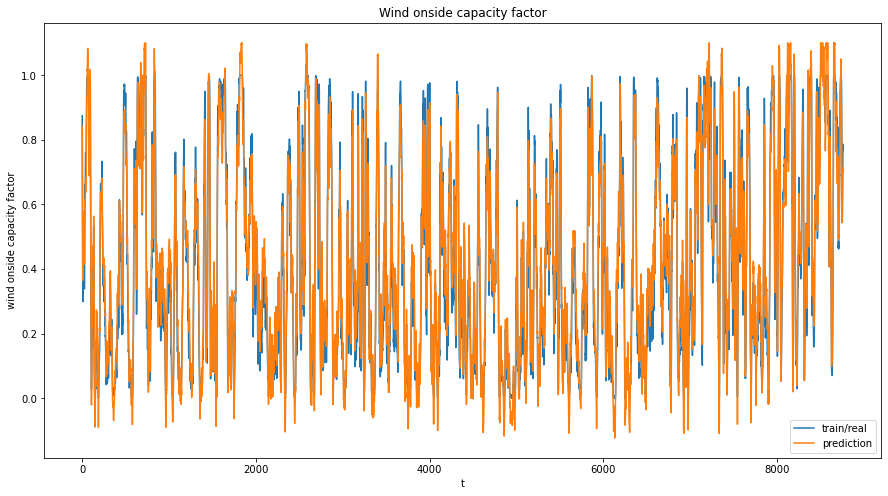

In [12]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

In [ ]:
qr = QuantileRegressor()
qr.fit(X_train, Y_train)
Y_predict = qr.predict(X_train)